## Figure 5
Difference in CDNC between 3 surface-partitioning models and constant surface tension at +200m in parcel simulation. 
Columns show results from different models (OV, SL, RU).
Rows show slices through the 3-dimensional phase space of Na-w-Forg.

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
import os
from joblib import Parallel, delayed
import pickle as pkl

from matplotlib import pyplot
from matplotlib.colors import TwoSlopeNorm
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling

from PySDM_examples.Singer_Ward import Settings, ParcelSimulation
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark
from PySDM_examples.Singer_Ward.constants_def import SINGER_CONSTS, plot_names

import warnings
from numba.core.errors import NumbaExperimentalFeatureWarning

In [9]:
CI = 'CI' in os.environ
n = 3

save = True
restore_saved_data = False

updrafts = np.geomspace(0.1, 10, 2 if CI else n)
forgs = np.linspace(0.05, 0.95, 2 if CI else n)
models = ('Constant', 'CompressedFilmOvadnevaite', 'SzyszkowskiLangmuir', 'CompressedFilmRuehl')

FORMULAE = Formulae(constants=SINGER_CONSTS)
# WATER_MOLAR_VOLUME = FORMULAE.constants.water_molar_volume
WATER_MOLAR_VOLUME = FORMULAE.constants.Mv / FORMULAE.constants.rho_w

In [7]:
def genkey(w, Forg, model):
    return f"w{w:.2f}_f{Forg:.2f}_{model}"

if restore_saved_data:
    with open('data_fig5.pkl','rb') as file:
        output = pkl.load(file)
else:
    def compute(key, settings):
        simulation = ParcelSimulation(settings)
        output = simulation.run()
        output['updraft'] = settings.w
        output['org_fraction'] = settings.aerosol.modes[0]['f_org']
        output['color'] = settings.aerosol.color
        return key, output

    print(f'tasks scheduled: {len(models) * len(forgs) * len(updrafts)}')
    output = dict(Parallel(verbose=10, n_jobs=-1)(
        delayed(compute)(genkey(w, Forg, model), Settings(
            dz = 1 * si.m, 
            n_sd_per_mode = 100, 
            model = model,
            aerosol = AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME, Forg=Forg, N=200),
            w = w * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
        ))
        for w in updrafts
        for Forg in forgs
        for model in models
    ))

    if save:
        with open('data_fig5.pkl','wb') as file:
            pkl.dump(output, file)

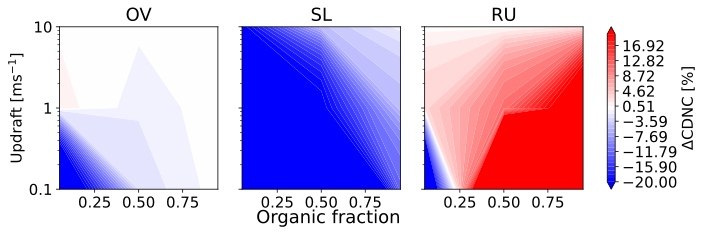

HTML(value="<a href='./fig5.pdf' target='_blank'>./fig5.pdf</a><br>")

In [8]:
dCDNC = np.zeros((len(models), len(updrafts), len(forgs)))
for m in range(0,3):
    for i,w in enumerate(updrafts):
        for j,Forg in enumerate(forgs):
            key_film = genkey(w, Forg, models[m+1])
            key_bulk = genkey(w, Forg, "Constant")
            z = np.array(output[key_bulk]['z'])
            wz = np.where(z == z[-1])[0][0]
            CDNC_film = np.array(output[key_film]['CDNC'])[wz]
            CDNC_bulk = np.array(output[key_bulk]['CDNC'])[wz]
            dCDNC[m,i,j] = (CDNC_film - CDNC_bulk) / CDNC_bulk * 100.0

pyplot.rcParams.update({"font.size":15})
fig, axes = pyplot.subplots(1, 4, figsize=(10,3), gridspec_kw={"width_ratios":[1,1,1,0.05]})

for i in range(0,3):
    ax = axes[i]
    ax.set_title(plot_names[models[i+1]])
    
    levs = np.linspace(-20,20,40)
    p = ax.contourf(forgs, updrafts, dCDNC[i], 
        cmap="bwr", levels=levs, extend="both")
    
    ax.set_yscale("log")
    if i == 0:
        ax.set_ylabel("Updraft [ms$^{-1}$]")
        ax.set_yticks([0.1,1,10])
        ax.set_yticklabels(["0.1","1","10"])
    elif i < 3:
        ax.set_yticklabels([])

fig.supxlabel("Organic fraction", y=-0.05)
pyplot.colorbar(p, cax=axes[-1], label=r"$\Delta$CDNC [%]")
pyplot.rcParams.update({'font.size': 15})
show_plot("fig5.pdf")